In [ ]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso


import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings

warnings.filterwarnings(action="ignore", message="Torchmetrics v0.9")


In [ ]:
pip install etna

In [ ]:
from etna.datasets import TSDataset

In [ ]:
media_wise = pd.read_excel("train.xlsx")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
media_wise

,year,week,weekB,SalesRub,Sales,SalesRubMonth,R1,R2,R3,R4,...,InvTVReg12,Total12,TRP13,CoverageTV13,InvTV13,InvDigital13,InvSponsorTV13,InvOON13,InvRadio13,Total13
0,2019,1,2018-12-31,41535567.34,114621.15,0.00,0.00,0.00,0.00,0.00,...,7155663.63,11834254.13,207.90,15.36,9085528.01,0.00,0.00,0.00,0.00,9085528.01
1,2019,2,2019-01-07,51222286.23,141523.20,0.00,0.00,0.00,0.00,0.00,...,8348274.24,13996532.16,317.47,25.53,10599782.68,0.00,0.00,0.00,0.00,10599782.68
2,2019,3,2019-01-14,57127348.91,157926.30,0.00,0.00,0.00,0.00,0.00,...,8348274.24,11466294.66,192.82,13.91,10599782.68,0.00,0.00,0.00,0.00,10599782.68
3,2019,4,2019-01-21,63040990.94,173746.65,0.00,0.00,0.00,0.00,0.00,...,8348274.24,10764632.16,138.37,8.05,10599782.68,0.00,0.00,0.00,0.00,10599782.68
4,2019,5,2019-01-28,67336888.87,185551.80,0.00,0.00,0.00,0.00,0.00,...,8477038.25,10984967.91,286.98,24.22,12893092.41,0.00,0.00,0.00,0.00,12893092.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,2024,49,2024-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,2024,50,2024-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
311,2024,51,2024-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,2024,52,2024-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def year_week_to_date(year, week):
    first_day_of_year = datetime.date(year, 1, 1)
    if first_day_of_year.weekday() <= 3:
        first_day_of_year -= datetime.timedelta(days=first_day_of_year.weekday())
    else:
        first_day_of_year += datetime.timedelta(days=7-first_day_of_year.weekday())
    week_start = first_day_of_year + datetime.timedelta(weeks=week-1)
    return week_start


media_wise['Дата'] = media_wise.apply(lambda row: year_week_to_date(row['year'], row['week']), axis=1)
media_wise = media_wise.sort_values('Дата')

In [ ]:
media_wise["timestamp"] = pd.to_datetime(media_wise["weekB"])
media_wise["target"] = media_wise["SalesRub"]
media_wise.drop(columns=["SalesRub","Дата"], inplace=True)
media_wise["segment"] = "main"
media_wise.head()

,year,week,weekB,Sales,SalesRubMonth,R1,R2,R3,R4,R5,...,CoverageTV13,InvTV13,InvDigital13,InvSponsorTV13,InvOON13,InvRadio13,Total13,timestamp,target,segment
0,2019,1,2018-12-31,114621.15,0.00,0.00,0.00,0.00,0.00,0.00,...,15.36,9085528.01,0.00,0.00,0.00,0.00,9085528.01,2018-12-31,41535567.34,main
1,2019,2,2019-01-07,141523.20,0.00,0.00,0.00,0.00,0.00,0.00,...,25.53,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-07,51222286.23,main
2,2019,3,2019-01-14,157926.30,0.00,0.00,0.00,0.00,0.00,0.00,...,13.91,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-14,57127348.91,main
3,2019,4,2019-01-21,173746.65,0.00,0.00,0.00,0.00,0.00,0.00,...,8.05,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-21,63040990.94,main
4,2019,5,2019-01-28,185551.80,0.00,0.00,0.00,0.00,0.00,0.00,...,24.22,12893092.41,0.00,0.00,0.00,0.00,12893092.41,2019-01-28,67336888.87,main


In [ ]:
from etna.datasets.tsdataset import TSDataset

media_wise = TSDataset.to_dataset(media_wise)
media_wise.head()

segment         main                                                   \
feature    BrandComp CoverageTV CoverageTV1 CoverageTV10 CoverageTV11   
timestamp                                                               
2018-12-31      0.00       0.00        0.00         0.00        21.92   
2019-01-07      0.00       0.00        0.00         0.00        19.04   
2019-01-14      0.00      32.80        0.00         0.00        18.89   
2019-01-21      0.00      25.56        0.00         0.00         6.78   
2019-01-28      0.00      26.79        0.00         0.00        30.19   

segment                                                                   ...  \
feature    CoverageTV12 CoverageTV13 CoverageTV2 CoverageTV3 CoverageTV4  ...   
timestamp                                                                 ...   
2018-12-31         9.84        15.36        0.00        0.00        0.00  ...   
2019-01-07        10.08        25.53        0.00        0.00        0.00  ...   
2019-01-14         6.13        13.91        0.00        0.00        0.00  ...   
2019-01-21        15.86         8.05        0.00        0.00        0.00  ...   
2019-01-28         6.15        24.22        0.00        0.00        0.00  ...   

segment                                                                       \
feature    Total5     Total6 Total7 Total8      Total9  Wordstat      target   
timestamp                                                                      
2018-12-31    NaN 3813979.04    NaN    NaN  5174523.64  76854.75 41535567.34   
2019-01-07    NaN 4449642.21    NaN    NaN  6036944.24  89113.50 51222286.23   
2019-01-14    NaN 4449642.21    NaN    NaN 12073888.48  96066.60 57127348.91   
2019-01-21    NaN 4449642.21    NaN    NaN         NaN  99189.30 63040990.94   
2019-01-28    NaN 4620378.18    NaN    NaN 11102095.65 108418.80 67336888.87   

segment                           
feature    week      weekB  year  
timestamp                         
2018-12-31    1 2018-12-31  2019  
2019-01-07    2 2019-01-07  2019  
2019-01-14    3 2019-01-14  2019  
2019-01-21    4 2019-01-21  2019  
2019-01-28    5 2019-01-28  2019  

[5 rows x 135 columns]

In [ ]:
ts = TSDataset(df=media_wise, freq="7D")

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:352: UserWarning: You probably set wrong freq. Discovered freq in you data is W-MON, you set 7D
  warnings.warn(


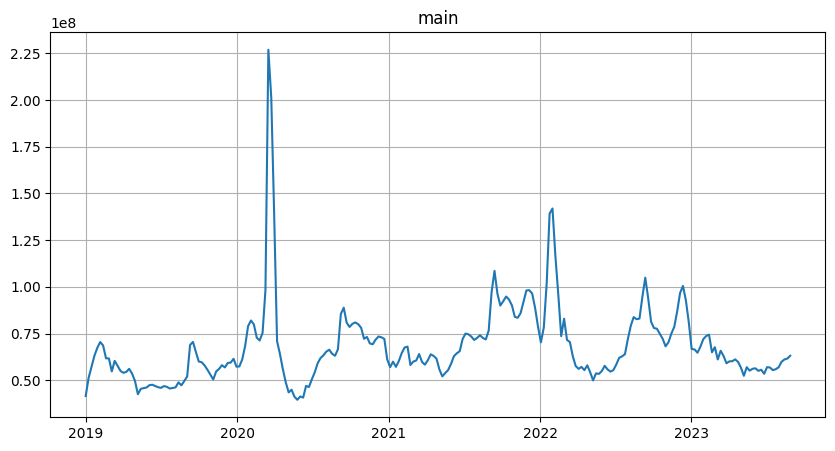

In [ ]:
ts.plot()

In [ ]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 134
num_regressors: 0
num_known_future: 0
freq: 7D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2018-12-31    2023-08-28     244            0


In [ ]:
from etna.analysis import plot_trend
from etna.transforms import LinearTrendTransform

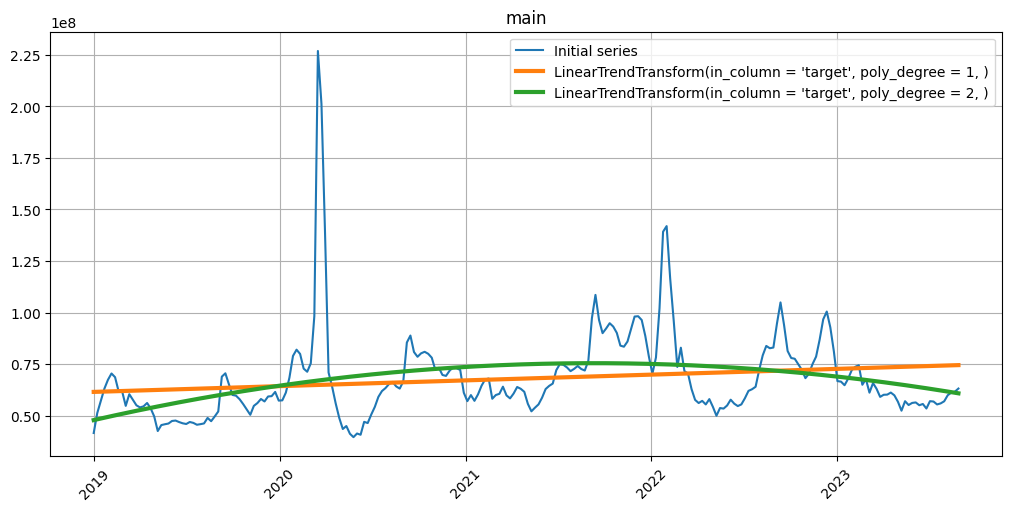

In [ ]:
trends = [
    LinearTrendTransform(in_column="target", poly_degree=1),
    LinearTrendTransform(in_column="target", poly_degree=2),
]
plot_trend(ts, trend_transform=trends)


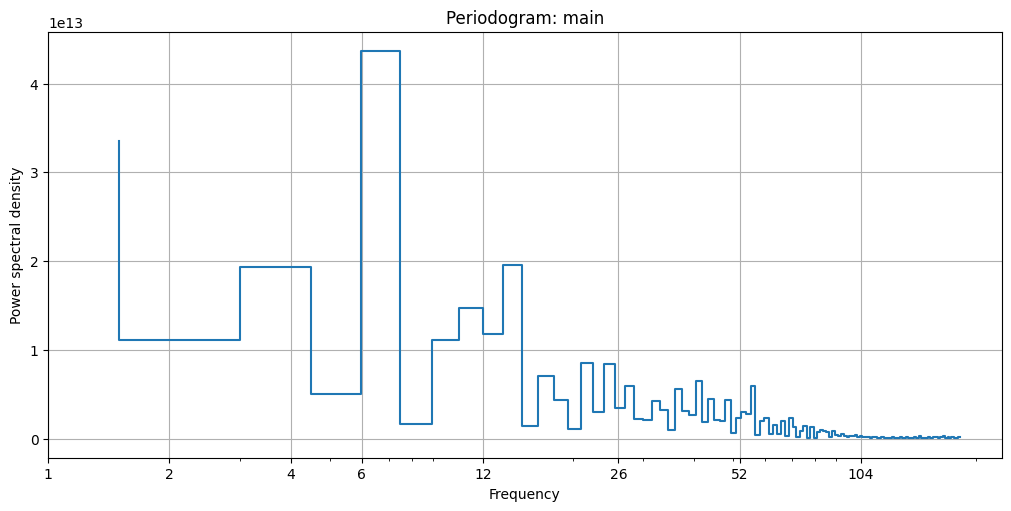

In [ ]:
from etna.analysis import plot_periodogram, stl_plot, seasonal_plot
plot_periodogram(ts, period=365.2425, amplitude_aggregation_mode="per-segment", xticks=[1, 2, 4, 6, 12, 26, 52, 104])


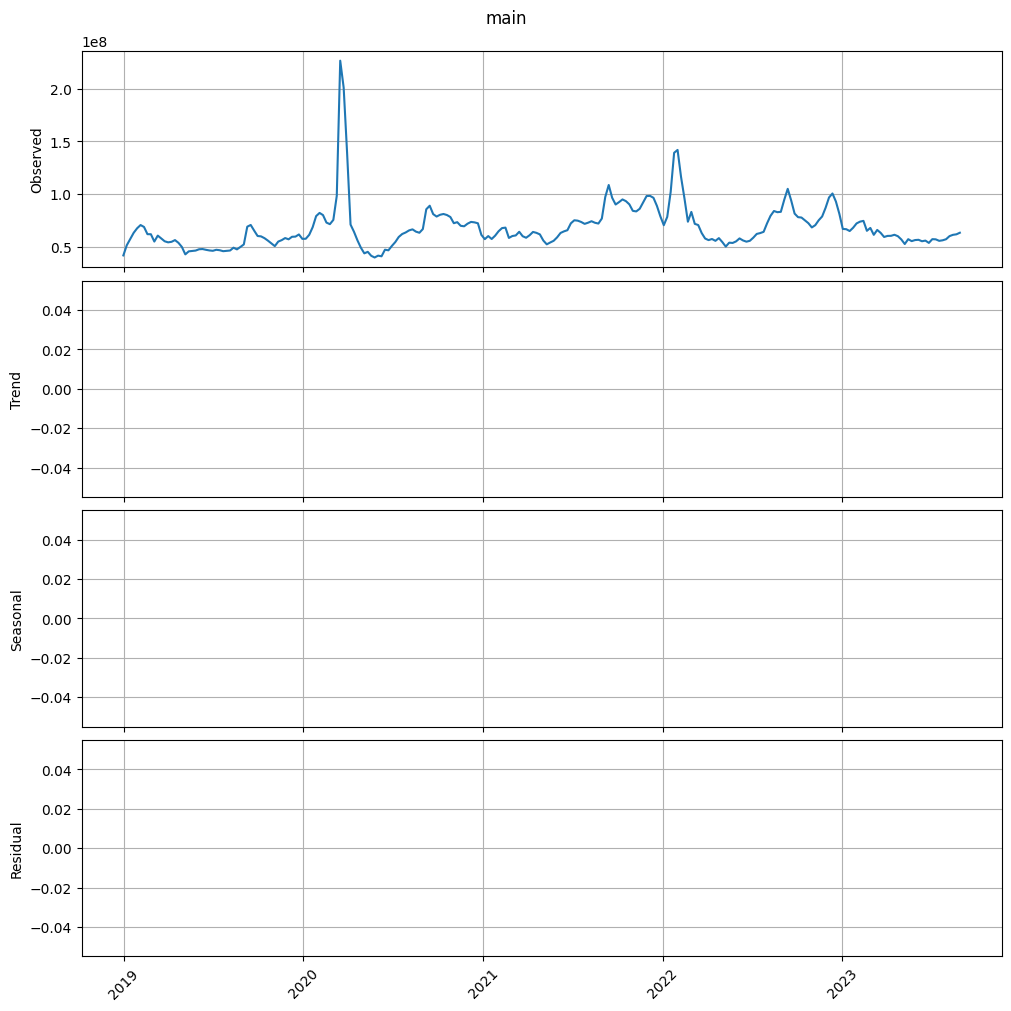

In [ ]:
stl_plot(ts=ts, period=52)


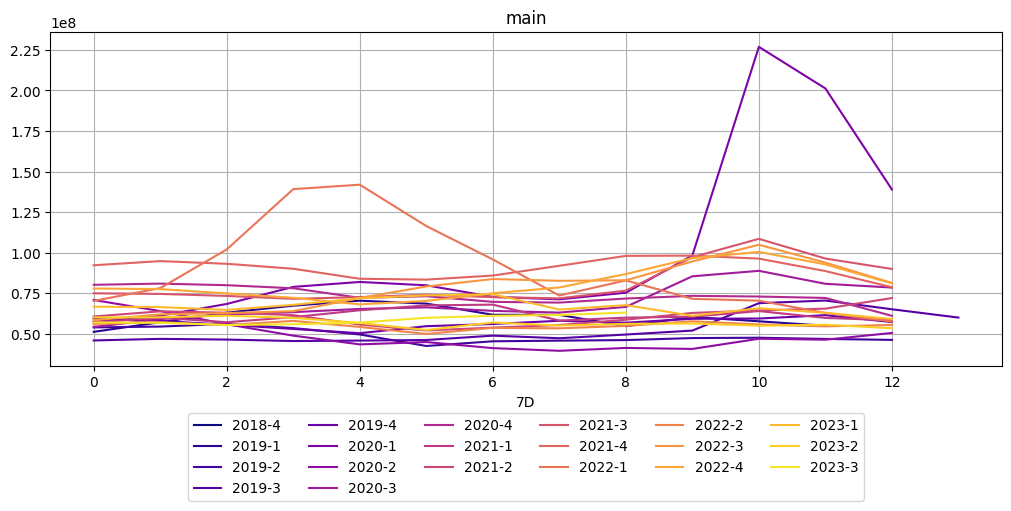

In [ ]:
seasonal_plot(ts=ts, cycle="quarter")


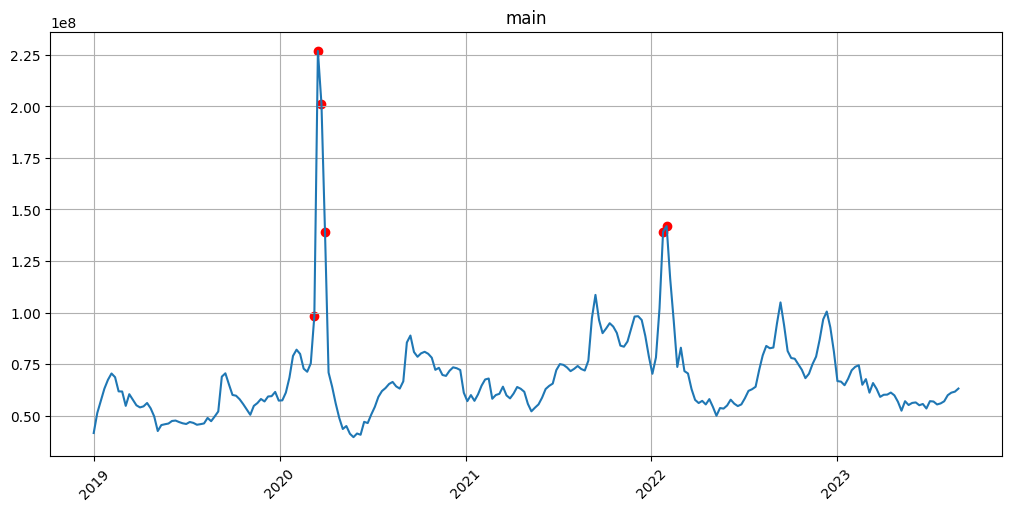

In [ ]:
from etna.analysis.outliers import get_anomalies_median, get_anomalies_density
from etna.analysis import plot_anomalies
anomaly_dict = get_anomalies_density(ts, window_size=18, distance_coef=1, n_neighbors=4)
plot_anomalies(ts, anomaly_dict)

In [ ]:
from etna.analysis import plot_time_series_with_change_points, plot_change_points_interactive
from etna.analysis import find_change_points
from ruptures.detection import Binseg

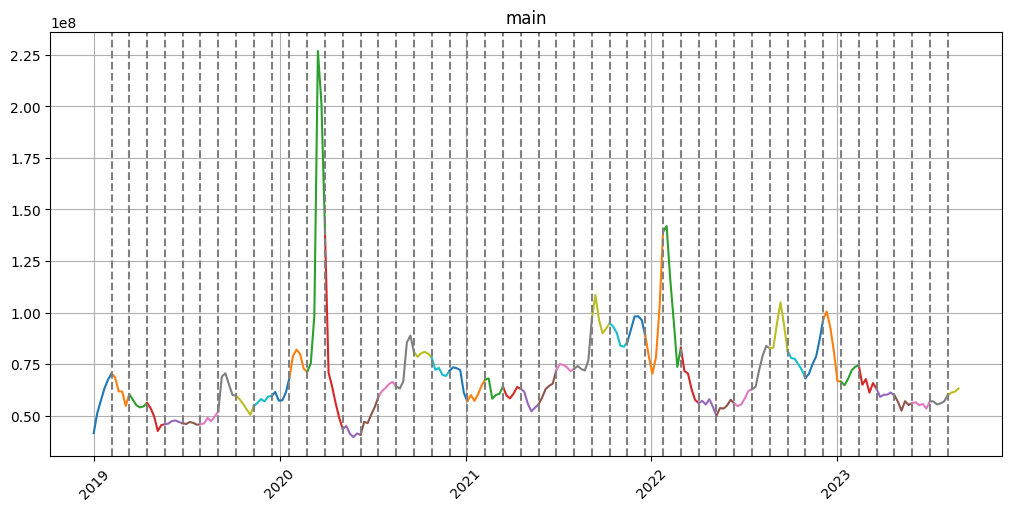

In [ ]:
change_points = find_change_points(ts=ts, in_column="target", change_point_model=Binseg(), pen=1e5)
plot_time_series_with_change_points(ts=ts, change_points=change_points)

In [ ]:
params_bounds = {"n_bkps": [0, 8, 2], "min_size": [1, 10, 3]}
plot_change_points_interactive(
    ts=ts,
    change_point_model=Binseg,
    model="l2",
    params_bounds=params_bounds,
    model_params=["min_size"],
    predict_params=["n_bkps"],
    figsize=(20, 10),
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='n_bkps', max=8, step=2, style=S…

In [ ]:
HORIZON = 8
from etna.models import NaiveModel
train_ts, test_ts = ts.train_test_split(
    train_start="2018-12-31",
    train_end="1993-12-01",
    test_start="1994-01-01",
    test_end="1994-08-01",
)
# Fit the model
model = NaiveModel(lag=12)
model.fit(train_ts)

# Make the forecast
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts, prediction_size=HORIZON)

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:1195: UserWarning: Min timestamp in df is 2018-12-31 00:00:00.
  warnings.warn(f"Min timestamp in df is {self.df.index.min()}.")
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:348: UserWarning: TSDataset freq can't be inferred
  warnings.warn("TSDataset freq can't be inferred")
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:348: UserWarning: TSDataset freq can't be inferred
  warnings.warn("TSDataset freq can't be inferred")
/usr/local/lib/python3.10/dist-packages/etna/models/seasonal_ma.py:64: UserWarning: This model doesn't work with exogenous features. Columns {'CoverageTV6', 'CoverageTV', 'InvDigital4', 'R3', 'InvDigital2', 'InvOON9', 'TRP11', 'InvRadio7', 'CoverageTV11', 'CoverageTV3', 'InvOON4', 'InvTV4', 'InvRadio6', 'InvTV5', 'Total4', 'CoverageTV7', 'InvRadio3', 'Total13', 'TRP3', 'InvSponsorTV8', 'CoverageTV2', 'InvTVReg5', 'Total2', 'Total9', 'R2', 'InvRadio5', 'Coverag

KeyError: NaT